In [1]:
from matplotlib import patches
from matplotlib import rcParams
from scipy import stats
import pandas as pd
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, Column, setdiff, join, unique
from photutils import detect_sources, deblend_sources
from photutils import CircularAperture, CircularAnnulus

from astroquery.vizier import Vizier
from astropy import units as u
from astropy.coordinates import SkyCoord
import re

from utils import *

rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '4'})
rcParams.update({'xtick.major.width': '1.'})
rcParams.update({'xtick.minor.pad': '5.0'})
rcParams.update({'xtick.minor.size': '4'})
rcParams.update({'xtick.minor.width': '0.8'})
rcParams.update({'ytick.major.pad': '5.0'})
rcParams.update({'ytick.major.size': '4'})
rcParams.update({'ytick.major.width': '1.'})
rcParams.update({'ytick.minor.pad': '5.0'})
rcParams.update({'ytick.minor.size': '4'})
rcParams.update({'ytick.minor.width': '0.8'})
rcParams.update({'font.size': 15})
rcParams.update({'font.serif': 'Times New Roman'})


In [2]:
read = True
save = False

mu: 884.42 , std: 4.96 , ZP: 27.10 , pix_scale: 2.50


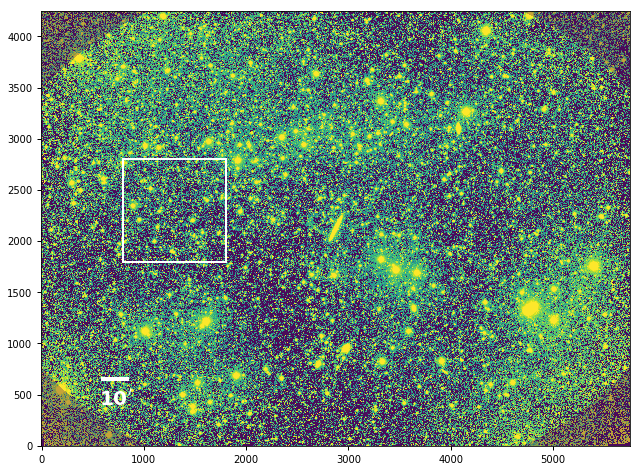

In [3]:
############################################
# Read 
############################################

hdu = fits.open("./coadd_SloanR_NGC_5907.fits")[0]
data = hdu.data
header = hdu.header
wcs_data = wcs.WCS(header)

seeing = 2.5
# Runned from create_photometric_light_APASS 
seg_map = fits.open("./SE_APASS/coadd_SloanR_NGC_5907_seg.fits")[0].data
weight_edge = fits.open("./weight_NGC5907.fits")[0].data
SE_cat_full = Table.read("./SE_APASS/coadd_SloanR_NGC_5907.cat", format="ascii.sextractor")

mu, std = np.float(hdu.header["BACKVAL"]), mad_std(hdu.data[seg_map==0&(weight_edge>0.5)]) 
ZP, pix_scale = np.float(hdu.header["REFZP"]), np.float(hdu.header["PIXSCALE"])
print("mu: %.2f , std: %.2f , ZP: %.2f , pix_scale: %.2f" %(mu, std, ZP, pix_scale))

SE_cat_full["RMAG_AUTO"] = -2.5*np.log10(SE_cat_full["FLUX_AUTO"]) + ZP

############################################
# Crop
############################################
patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (800, 1800, 1800, 2800)
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (800, 600, 1800, 1600)
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (3000, 1400, 4000, 2400)
image_bounds = (patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax)
        
patch, seg_patch = crop_image(data, seg_map, image_bounds, weight_map=weight_edge, 
                              sky_mean=mu, sky_std=std, color="w",draw=True)

if read:
    table_res_Rnorm = Table.read("./Rnorm_8pix_15mag_X%dY%d.txt"%(patch_Xmin, patch_Ymin), format="ascii")
    table_res_Rnorm = crop_catalog(table_res_Rnorm, bounds=image_bounds)

In [21]:
############################################
# Crossmatch
############################################

result = query_vizier(catalog_name="URAT", radius=2*u.deg, header=header,
                      columns=['RAJ2000', 'DEJ2000', 'mfa', 'gmag', 'e_gmag', 'rmag', 'e_rmag'],
                      column_filters={'mfa':'=1', 'rmag':'{0} .. {1}'.format(8, 18)})

Cat_URAT = result['I/329/urat1']
Cat_URAT = transform_coords2pixel(Cat_URAT, cat_name="URAT")     
print("URAT Brightest Star: %.3f"%Cat_URAT["rmag"].min())
    
result = query_vizier(catalog_name="USNO", radius=2*u.deg, header=header,
                      columns=['RAJ2000', 'DEJ2000', "Bmag","Rmag"],
                      column_filters={"Rmag":'{0} .. {1}'.format(5, 15)})

Cat_USNO = result['I/252/out']
Cat_USNO = transform_coords2pixel(Cat_USNO, cat_name="USNO")
print("USNO Brightest Star: %.3f"%Cat_USNO["Rmag"].min())

############################################
# Merge Catalog
############################################

df_match_URAT = merge_catalog(SE_cat_full, Cat_URAT, sep=2.5*u.arcsec, 
                              keep_columns=["NUMBER","X_IMAGE","Y_IMAGE","ELLIPTICITY","RMAG_AUTO", 'FWHM_IMAGE',
                                            "ID_URAT","X_IMAGE_URAT","Y_IMAGE_URAT","rmag","gmag","FLAGS"])
df_match_USNO = merge_catalog(SE_cat_full, Cat_USNO, sep=5*u.arcsec,
                               keep_columns=["NUMBER","X_IMAGE","Y_IMAGE","ELLIPTICITY","RMAG_AUTO",
                                             "ID_USNO","X_IMAGE_USNO","Y_IMAGE_USNO","Rmag","FLAGS"])

df_SE_match_all = pd.merge(df_match_URAT, df_match_USNO, how='outer')

bounds = (patch_Xmin-200, patch_Ymin-200, patch_Xmax+200, patch_Ymax+200)
df_SE_match = crop_catalog(df_SE_match_all, bounds, keys=("X_IMAGE", "Y_IMAGE"))
df_SE_match = df_SE_match.reset_index(drop=True)

target = df_SE_match["RMAG_AUTO"] < 15
df_SE_target = df_SE_match[target].reset_index()
df_SE_target

URAT Brightest Star: 10.021
USNO Brightest Star: 7.000


,index,NUMBER,X_IMAGE,Y_IMAGE,ELLIPTICITY,FWHM_IMAGE,FLAGS,RMAG_AUTO,ID_URAT,gmag,rmag,X_IMAGE_URAT,Y_IMAGE_URAT,ID_USNO,Rmag,X_IMAGE_USNO,Y_IMAGE_USNO
0,0,10981,1318.3895,2985.3862,0.055,2.87,2,14.760577,3216.0,15.121000,14.633,1318.2525,2985.3486,2905.0,14.6,1318.0346,2985.2190
1,1,10985,609.3795,2999.0608,0.094,2.97,3,13.899152,3344.0,14.227000,13.741,609.2384,2999.0667,3352.0,13.5,609.0335,2999.4069
2,5,11154,1078.7504,2988.9346,0.069,2.89,0,14.168863,3223.0,14.832000,13.990,1078.6116,2989.0149,3070.0,13.8,1078.5596,2990.0340
3,7,11228,924.9524,2979.1204,0.132,3.03,0,13.406135,3081.0,14.530000,13.228,924.6094,2979.0256,NaN,NaN,NaN,NaN
4,9,11293,1734.4144,2961.5969,0.046,4.13,6,11.809956,3185.0,11.856000,11.100,1734.1376,2961.5843,2581.0,11.6,1733.7508,2961.6677
5,10,11360,1105.9899,2966.5188,0.142,3.25,4,12.764730,3220.0,13.348000,12.561,1105.7555,2966.5095,3049.0,12.5,1105.7255,2966.5771
6,11,11383,1008.5241,2901.5034,0.305,2.86,3,14.678931,3079.0,15.081000,14.571,1008.4698,2901.4529,3123.0,14.6,1008.5057,2901.6069
7,13,11411,1819.5680,2965.5864,0.104,2.74,0,14.547001,3552.0,14.791000,14.418,1819.5034,2965.6093,2518.0,14.3,1819.4052,2965.8912
8,16,11471,1348.5474,2949.1829,0.077,2.84,2,13.679416,3208.0,13.773000,13.526,1348.4527,2949.1879,2879.0,13.6,1348.5022,2949.4691
9,17,11478,1939.9355,2943.9451,0.097,4.19,6,11.281835,3532.0,10.529000,10.036,1939.6365,2943.8519,2427.0,10.9,1939.1548,2943.3189


In [5]:
############################################
# Measure
############################################

def get_star_pos(id, star_cat, ref_pos=(0,0)):
    X_c, Y_c = star_cat[id]["X_IMAGE"]-ref_pos[0], star_cat[id]["Y_IMAGE"]-ref_pos[1]
    return (X_c, Y_c)

def get_star_thumb(id, star_cat, data=data, seg_map=seg_map, 
                   n_win=20, ref_pos=(0,0), seeing=2.5, w=wcs_data, verbose=True):
    (X_c, Y_c) = get_star_pos(id, star_cat, ref_pos=ref_pos)    
    
    fwhm =  max(star_cat[id]["FWHM_IMAGE"], seeing)
    win_size = int( n_win * min(max(fwhm,2), 8))
    
    X_min, X_max = X_c - win_size, X_c + win_size
    Y_min, Y_max = Y_c - win_size, Y_c + win_size
    x_min, y_min = coord_Im2Array(X_min, Y_min)
    x_max, y_max = coord_Im2Array(X_max, Y_max)
    
    if verbose:
        num = star_cat[id]["NUMBER"]
        print("NUMBER: ",num)
        print("X_c, Y_c: ", (X_c, Y_c))
        print("x_min, x_max, y_min, y_max: ", x_min, x_max, y_min, y_max)
    
    img_thumb = data[ref_pos[0]+x_min:ref_pos[0]+x_max, ref_pos[1]+y_min:ref_pos[1]+y_max].copy()
    seg_thumb = seg_map[ref_pos[0]+x_min:ref_pos[0]+x_max, ref_pos[1]+y_min:ref_pos[1]+y_max]
    mask_thumb = (seg_thumb!=0)    
    
    X_cen, Y_cen = w.wcs_world2pix(star_cat[id]["X_WORLD"], star_cat[id]["Y_WORLD"], 1)
    cen_star = X_cen - (y_min+1), Y_cen - (x_min+1)
    
    return img_thumb, seg_thumb, mask_thumb, cen_star
    
def extract_star(id, star_cat, data=data, seg_map=seg_map, 
                 seeing=2.5, sn_thre=2., n_win=20,
                 display_bg=False, display=True, verbose=False):
    
    img_thumb, seg_thumb, mask_thumb, cen_star = get_star_thumb(id, star_cat, data=data, seg_map=seg_map,
                                                                n_win=n_win, seeing=seeing, verbose=verbose)
    fwhm = max([star_cat[id]["FWHM_IMAGE"], seeing])

    b_size = round(img_thumb.shape[0]//5/25)*25
    if img_thumb.shape[0] > 50:
        back, back_rms = background_sub_SE(img_thumb, b_size=b_size)
    else:
        back, back_rms = (np.median(img_thumb[~mask_thumb])*np.ones_like(img_thumb), 
                            mad_std(img_thumb[~mask_thumb])*np.ones_like(img_thumb))
    if display_bg:
            display_background_sub(img_thumb, back)        
            
    # do segmentation (second time, target-based)
    sigma = seeing * gaussian_fwhm_to_sigma
    threshold = back + (sn_thre * back_rms)
    segm = detect_sources(img_thumb, threshold, npixels=5)
    
    # deblending
    segm_deblend = deblend_sources(img_thumb, segm, npixels=5,
                                   nlevels=64,
                                   contrast=0.005)
    star_lab = segm_deblend.data[img_thumb.shape[0]//2, img_thumb.shape[1]//2]
    star_ma = ~((segm_deblend.data==star_lab) | (segm_deblend.data==0)) # mask other source
    
    # display
    if display:
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(21,5))
        ax1.imshow(img_thumb, vmin=np.median(back)-1, vmax=10000, norm=norm1, origin="lower", cmap="viridis")
        ax1.set_title("star", fontsize=15)
        ax2.imshow(segm, origin="lower", cmap=segm.make_cmap(random_state=12345))
        ax2.set_title("segment", fontsize=15)
        ax3.imshow(segm_deblend, origin="lower", cmap=segm_deblend.make_cmap(random_state=12345))
        ax3.set_title("deblend", fontsize=15)

        img_thumb_ma = img_thumb.copy()
        img_thumb_ma[star_ma] = -1
        ax4.imshow(img_thumb_ma, origin="lower", cmap="viridis", 
                   vmin=np.median(back)-1, vmax=np.median(back)+10*np.median(back_rms), norm=norm2)
        ax4.set_title("extracted star", fontsize=15)
    
    return img_thumb, star_ma, back, cen_star

def compute_Rnorm(image, mask_field, cen, R=8, wid=0.5, display=False):
    """ Return sigma-clipped mean, med and std of ring r=R (half-width=wid) for image"""
    annulus = CircularAnnulus(cen, R-wid, R+wid)
    annulus_ma = annulus.to_mask()      
    mask_ring = annulus_ma.to_image(image.shape)>0.5    # sky ring (R-wid, R+wid)
    mask_clean = mask_ring & (~mask_field)            # sky ring with other sources masked
    z_mean, z_med, z_std = sigma_clipped_stats(image[mask_clean], sigma=3)
    
    if display:
        plt.imshow(mask_clean*image, origin="lower", cmap="gray", norm=norm1, vmin=z_med-5*z_std, vmax=z_med+5*z_std)
    
    return z_mean, z_med, z_std

def compute_Rnorm_batch(tab_SE_target, SE_catalog=SE_cat_full, R=8, wid=0.5, return_full=False):
    res_thumb = {}    
    res_Rnorm = np.empty((len(tab_SE_target),4))
    for i, (num, rmag_auto) in enumerate(zip(tab_SE_target['NUMBER'], tab_SE_target['RMAG_AUTO'])):
        process_counter(i, len(tab_SE_target))

        ind = num - 1
        n_win = 30 if rmag_auto< 11 else 20
            
        img, ma, bkg, cen = extract_star(ind, SE_cat_full, n_win=n_win, display_bg=False, display=False)
        
        res_thumb[num] = {"image":img, "mask":ma, "bkg":bkg, "center":cen}
        
        z_mean, z_med, z_std = compute_Rnorm(img, ma, cen, R=R, wid=wid)
        sky_mean = np.median(bkg)
        res_Rnorm[i] = np.array([z_mean, z_med, z_std, sky_mean])
    return res_Rnorm, res_thumb

In [25]:
if read is False:
    res_Rnorm, res_thumb = compute_Rnorm_batch(df_SE_target, SE_catalog=SE_cat_full, R=10, wid=0.5, return_full=True)

    save_thumbs(res_thumb, 'Thumb_15mag_X%sY%s'%(patch_Xmin, patch_Ymin))
    
    table_res_Rnorm = Table(np.hstack([df_SE_target['NUMBER'].values[:, None],
                                       df_SE_target['X_IMAGE'].values[:, None],
                                       df_SE_target['Y_IMAGE'].values[:, None], res_Rnorm]), 
                         names=['NUMBER','X_IMAGE','Y_IMAGE','mean','med','std','sky'], dtype=['int']+['float']*6)
if save:
    table_res_Rnorm.write('Rnorm_8pix_15mag_X%sY%s.txt'%(patch_Xmin, patch_Ymin), overwrite=True, format='ascii')

/home/qliu/Desktop/PSF/utils.py:45: RuntimeWarning: divide by zero encountered in log10
  I_SB = -2.5*np.log10(y - BKG) + ZP + 2.5 * np.log10(pix_scale**2)
/home/qliu/Desktop/PSF/utils.py:45: RuntimeWarning: invalid value encountered in log10
  I_SB = -2.5*np.log10(y - BKG) + ZP + 2.5 * np.log10(pix_scale**2)
/home/qliu/Desktop/PSF/utils.py:45: RuntimeWarning: invalid value encountered in log10
  I_SB = -2.5*np.log10(y - BKG) + ZP + 2.5 * np.log10(pix_scale**2)


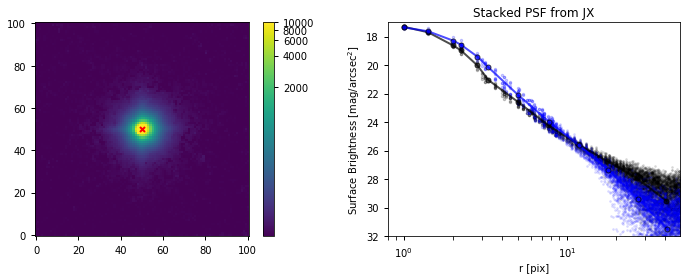

In [16]:
hdu = fits.open("./med_psf_JX.fits")[0]
hdu_p = fits.open("./median_psf_patch.fits")[0]
PSF_JX = hdu.data * 10 + mu
PSF_JX_p = hdu_p.data * 1e5 + mu

fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im = ax1.imshow(PSF_JX_p, vmin=mu, vmax=10000, norm=norm1, aspect="equal", origin="lower", cmap="viridis")
ax1.plot(50,50,"rx",ms=5,mew=2)
colorbar(im)

ax2 = plt.subplot(122)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50),
                                             ZP=ZP, sky_mean=mu, sky_std=1, pix_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="k",
                                             scatter=True, core_undersample=True)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX_p, cen=(50,50),
                                             ZP=ZP, sky_mean=mu, sky_std=1, pix_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="b",
                                             scatter=True, core_undersample=True)
plt.ylim(32,17)
plt.title("Stacked PSF from JX")
plt.tight_layout()

In [22]:
import random
colour = [ "indianred", "steelblue", "seagreen", "gold", "lightcyan", "orchid", "orange", "gray", "brown" ]
random.seed(88)
rand_colours = [random.choice(colour) for i in range(len(df_SE_target))]

r = np.logspace(0.03,2.5,100)

def plot_fit_res_SB(res, r=r):
    pmed, pmean, pcov = get_params_fit(res)
    print("Fit results: ", pmed)

    # PSF Parameters
    n_fit = pmed[1]                     # true power index
    f_fit = 10**pmed[0]                 # fraction of power law component
    theta_t = 5.
    theta_t_pix = theta_t / pix_scale 

    beta_psf = 10
    fwhm = 2.28 * pix_scale                         # moffat fwhm, in arcsec

    gamma = fwhm / 2. / np.sqrt(2**(1./beta_psf)-1)  # moffat core width, in arcsec
    gamma_pix = gamma / pix_scale  

    c_mof2Dto1D =  C_mof2Dto1D(gamma_pix, beta_psf)
    c_pow2Dto1D = C_pow2Dto1D(n_fit, theta_t_pix)

    I_15mag, I_12mag, I_9mag = [10**((mag-ZP)/-2.5) for mag in [15,12,9]]
    comp1 = moffat1d_normed(r, gamma=gamma_pix, alpha=beta_psf) / c_mof2Dto1D 
    comp2 = trunc_power1d_normed(r, n_fit, theta_t_pix) / c_pow2Dto1D

    [I_tot_15, I_tot_12, I_tot_9] = [Intensity2SB(((1-f_fit) * comp1 + comp2 * f_fit) * I, 0, ZP, pix_scale)
                                      for I in [I_15mag, I_12mag, I_9mag]]
    return I_tot_15, I_tot_12, I_tot_9

### Patch [800, 1800, 800, 2800] stars < 15 mag

In [23]:
fit_res1 = open_nested_fitting_result(filename='./real/fit_real_best_X800Y1800.res')
I_tot_15, I_tot_12, I_tot_9 = plot_fit_res_SB(fit_res1)

Fit results:  [-5.12792608e-01  3.56095093e+00  8.84061314e+02  2.69474860e+00]


In [31]:
load_thumbs('Thumb_15mag_X800Y1800')

Read thumbs from: Thumb_15mag_X800Y1800


{13075: {'image': array([[ 914.69605625,  911.47162035,  913.00660729, ...,  909.61408414,
           938.1182742 , 1000.32328897],
         [ 933.66155577,  928.50944438,  920.84712141, ...,  907.72952858,
           924.01738314,  951.06024429],
         [ 966.9199942 ,  954.65607445,  939.42308859, ...,  906.30216353,
           914.06059371,  924.3613677 ],
         ...,
         [ 886.30793791,  889.62687248,  890.74004822, ...,  886.35102458,
           885.63539818,  884.05175071],
         [ 891.65207084,  889.10231023,  889.78081365, ...,  883.25268467,
           883.59615797,  887.0106131 ],
         [ 890.76609597,  890.26729531,  890.50429179, ...,  885.12938797,
           883.73923839,  882.69350393]]),
  'mask': array([[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [False, F

In [29]:
if read:
    z_mean_s, z_med_s = table_res_Rnorm['mean'],table_res_Rnorm['med'] 
    z_std_s, sky_mean_s = table_res_Rnorm['std'],table_res_Rnorm['sky']
    res_thumb = load_thumbs('Thumb_15mag_X800Y1800')

else:
    z_mean_s, z_med_s, z_std_s, sky_mean_s = res_Rnorm.T

plt.figure(figsize=(10,8))
for num, rmag, sky_m, c in zip(df_SE_target["NUMBER"],df_SE_target["RMAG_AUTO"], sky_mean_s, rand_colours):
    img, ma, cen = res_thumb['image'][num], res_thumb['mask'][num], res_thumb['center'][num]
    alpha = min(0.1*(16-rmag), 0.7) 
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                 ZP=ZP, sky_mean=sky_m, sky_std=std,
                                                 xunit="pix", yunit="SB", color=c, lw=1, alpha=alpha)

plt.fill_betweenx([32, 16.], x1=7.5, x2=8.5, color="gold", alpha=0.3)

for z_m, z_std, sky_m, c in zip(z_mean_s, z_std_s, sky_mean_s, rand_colours):
    plt.plot(8, Intensity2SB(z_m, sky_m, ZP, pix_sc|ale),"*", ms=10, color=c, alpha=0.5, zorder=3)

r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50), mask=None, 
                                         ZP=ZP, sky_mean=mu, sky_std=2.5, pix_scale=pix_scale, dr=1,
                                         xunit="pix", yunit="SB", color="k", lw=4, label="Stacked PSF (JX)",
                                         core_undersample=True, plot_line=False)
for k, I in enumerate([I_tot_9, I_tot_12, I_tot_15]):
    lab = "Fit (1D profile)" if k==0 else None
    plt.plot(r, I, color="r", ls="--", lw=3, label=lab, zorder=3, alpha=0.9)

plt.legend(fontsize=14)
plt.ylim(32,16.)
plt.xlim(0.9,220)

Read thumbs from: Thumb_15mag_X800Y1800


ValueError: too many values to unpack (expected 4)

### Another patch [800, 600, 1800, 1600]  containing brighter stars (the same fit)

In [104]:
fit_res2 = open_nested_fitting_result(filename='./real/fit_real_best_X800Y600.res')
I_tot_15, I_tot_12, I_tot_9 = plot_fit_res_SB(fit_res2)

Fit results:  [-7.53674241e-01  3.37092177e+00  8.86120569e+02  3.44800822e+00]


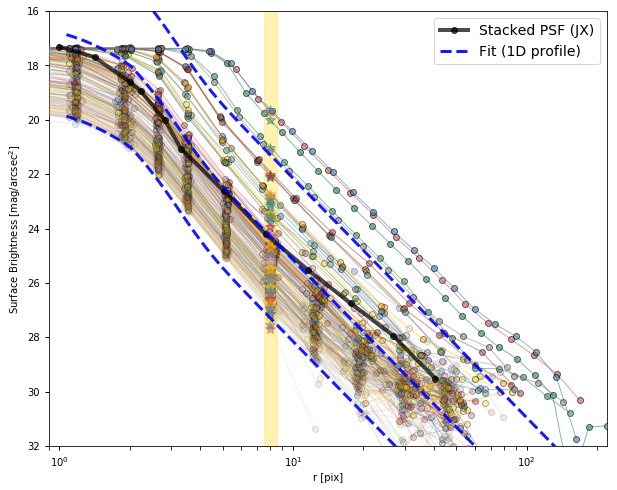

In [90]:
if draw:
    import random
    colour = [ "indianred", "steelblue", "seagreen", "gold", "plum", "orange", "gray", "brown" ]
    random.seed(42)
    rand_colours = [random.choice(colour) for i in range(len(df_SE_target))]
    
    if read:
        z_mean_s, z_med_s = table_res_Rnorm['mean'],table_res_Rnorm['med'] 
        z_std_s, sky_mean_s = table_res_Rnorm['std'],table_res_Rnorm['sky']
    else:
        z_mean_s, z_med_s, z_std_s, sky_mean_s = res_Rnorm.T

    plt.figure(figsize=(10,8))
    for num, rmag, sky_m, c in zip(df_SE_target["NUMBER"],df_SE_target["RMAG_AUTO"], sky_mean_s, rand_colours):
        img, ma, cen = img_s[num], ma_s[num], cen_s[num]
        alpha = min(0.1*(16-rmag), 0.7)
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                     ZP=ZP, sky_mean=sky_m, sky_std=std,
                                                     xunit="pix", yunit="SB", color=c, lw=1, alpha=alpha)

    plt.fill_betweenx([32, 16.], x1=7.5, x2=8.5, color="gold", alpha=0.3)
    
    for z_m, z_std, sky_m, c in zip(z_mean_s, z_std_s, sky_mean_s, rand_colours):
        plt.plot(8, Intensity2SB(z_m, sky_m, ZP, pix_scale),"*", ms=10, color=c, alpha=0.5, zorder=3)
    
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50), mask=None, 
                                             ZP=ZP, sky_mean=mu, sky_std=2.5, pix_scale=pix_scale, dr=1,
                                             xunit="pix", yunit="SB", color="k", lw=4, label="Stacked PSF (JX)",
                                             core_undersample=True, plot_line=False)
    for k, I in enumerate([I_tot_9, I_tot_12, I_tot_15]):
        lab = "Fit (1D profile)" if k==0 else None
        plt.plot(r, I, color="b", ls="--", lw=3, label=lab, zorder=3, alpha=0.9)
    
    plt.legend(fontsize=14)
    plt.ylim(32,16.)
    plt.xlim(0.9,220)